In [1]:
"""
NLP-Powered Disease Diagnosis: Model Development Notebook

This Jupyter Notebook constitutes the complete data science development and
processing phase for an NLP-powered disease diagnosis system. It takes a raw
dataset of diseases and their corresponding symptoms, and produces the core
assets required for a real-time, interactive web application.

The primary functions of this notebook are:
- To perform Exploratory Data Analysis (EDA) to understand the dataset's
  characteristics and justify the choice of a semantic search approach.
- To preprocess and standardize the textual symptom data for optimal model
  performance and compatibility.
- To generate high-dimensional semantic vector embeddings for each disease's
  symptoms using a state-of-the-art Sentence-Transformer model.
- To develop and validate the core diagnosis function, which uses cosine
  similarity to find and rank diseases based on a user's natural language query.
"""

"\nNLP-Powered Disease Diagnosis: Model Development Notebook\n\nThis Jupyter Notebook constitutes the complete data science development and\nprocessing phase for an NLP-powered disease diagnosis system. It takes a raw\ndataset of diseases and their corresponding symptoms, and produces the core\nassets required for a real-time, interactive web application.\n\nThe primary functions of this notebook are:\n- To perform Exploratory Data Analysis (EDA) to understand the dataset's\n  characteristics and justify the choice of a semantic search approach.\n- To preprocess and standardize the textual symptom data for optimal model\n  performance and compatibility.\n- To generate high-dimensional semantic vector embeddings for each disease's\n  symptoms using a state-of-the-art Sentence-Transformer model.\n- To develop and validate the core diagnosis function, which uses cosine\n  similarity to find and rank diseases based on a user's natural language query.\n"

In [2]:
# --- Setup and Library Imports ---

# --- Core Libraries ---
import os
import pandas as pd
import numpy as np

# --- NLP and Machine Learning ---
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Utility ---
import warnings
warnings.filterwarnings('ignore')

# --- Pandas Display Options ---
# This helps in viewing the full content of columns without truncation
pd.set_option('display.max_colwidth', None)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [3]:
# --- Data Loading and Initial Inspection ---

# The professional way: Load data from an external file.
# This separates your code from your data, which is a core best practice.
try:
    symptoms_df = pd.read_csv('data/Diseases_Symptoms.csv')
    print("✅ Data loaded successfully from 'data/Diseases_Symptoms.csv'")
except FileNotFoundError:
    print("❌ ERROR: 'Diseases_Symptoms.csv' not found.")
    print("Please make sure the CSV file is in a 'data' subfolder inside your project directory.")
    # Create an empty df to avoid further errors and allow the notebook to run.
    symptoms_df = pd.DataFrame() 

# --- Initial Inspection ---
if not symptoms_df.empty:
    print("\n--- DataFrame Info ---")
    symptoms_df.info()

    print("\n--- First 5 Rows ---")
    display(symptoms_df.head())

    print("\n--- Missing Values Check ---")
    # In a real dataset, we might have missing values. It's good practice to check.
    print(symptoms_df.isnull().sum())

✅ Data loaded successfully from 'data/Diseases_Symptoms.csv'

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Name          405 non-null    object
 1   Symptoms      405 non-null    object
 2   Treatments    404 non-null    object
 3   Disease_Code  405 non-null    object
 4   Contagious    405 non-null    bool  
 5   Chronic       405 non-null    bool  
dtypes: bool(2), object(4)
memory usage: 13.6+ KB

--- First 5 Rows ---


,Name,Symptoms,Treatments,Disease_Code,Contagious,Chronic
0,Gestational Cholestasis,"Itchy skin, particularly on the hands and feet",NaN,D001,False,False
1,Injury to Internal Organ,"Abdominal pain, bleeding, organ dysfunction","Immediate medical attention, diagnostic tests, surgery (in some cases)",D002,False,False
2,Scabies,"Intense itching, especially at night, small blisters or bumps","Prescription medications (topical or oral scabicides), washing clothes and bedding in hot water, vacuuming and cleaning home",D003,False,True
3,Congenital Glaucoma,"Cloudy or hazy eyes, excessive tearing, sensitivity to light","Surgery (e.g., trabeculotomy, goniotomy) to create a new drainage pathway, medications to reduce intraocular pressure",D004,False,True
4,Avoidant/Restrictive Food Intake Disorder (ARFID),"Avoidance or restriction of certain foods or entire food groups, significant weight loss or failure to gain weight","Nutritional counseling, psychotherapy (such as cognitive-behavioral therapy or family-based therapy), medical monitoring, exposure therapy, occupational therapy",D005,False,True



--- Missing Values Check ---
Name            0
Symptoms        0
Treatments      1
Disease_Code    0
Contagious      0
Chronic         0
dtype: int64


--- 2.1: Distribution of 'Chronic' and 'Contagious' flags ---


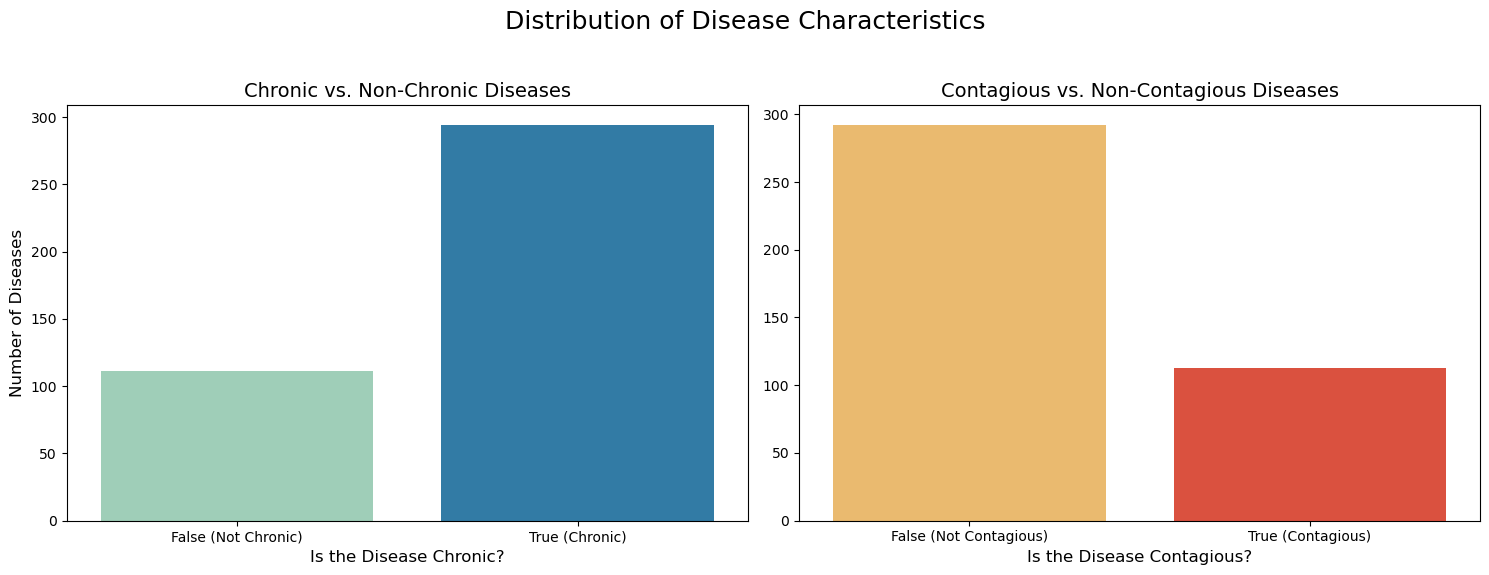


--- 2.2: Analysis of Text Feature Lengths ---

--- Descriptive Statistics for Symptom and Treatment Counts ---


,symptom_count,treatment_count
count,405.000000,405.000000
mean,4.197531,4.972840
std,2.182399,2.546936
min,1.000000,0.000000
25%,3.000000,3.000000
50%,4.000000,4.000000
75%,5.000000,6.000000
max,12.000000,14.000000


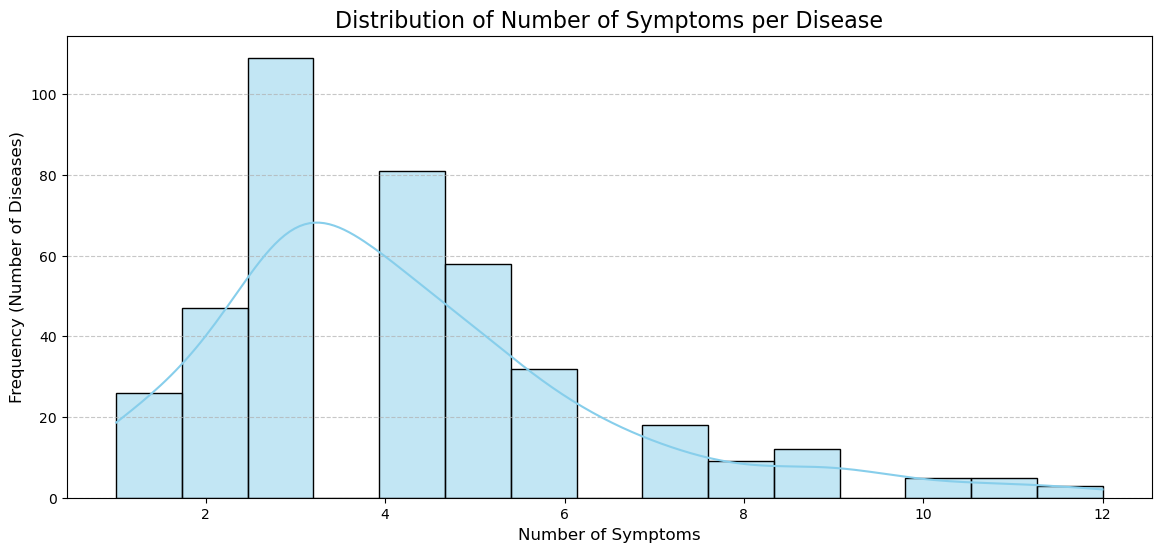


--- 2.3: Most Common Words in Symptom Descriptions ---


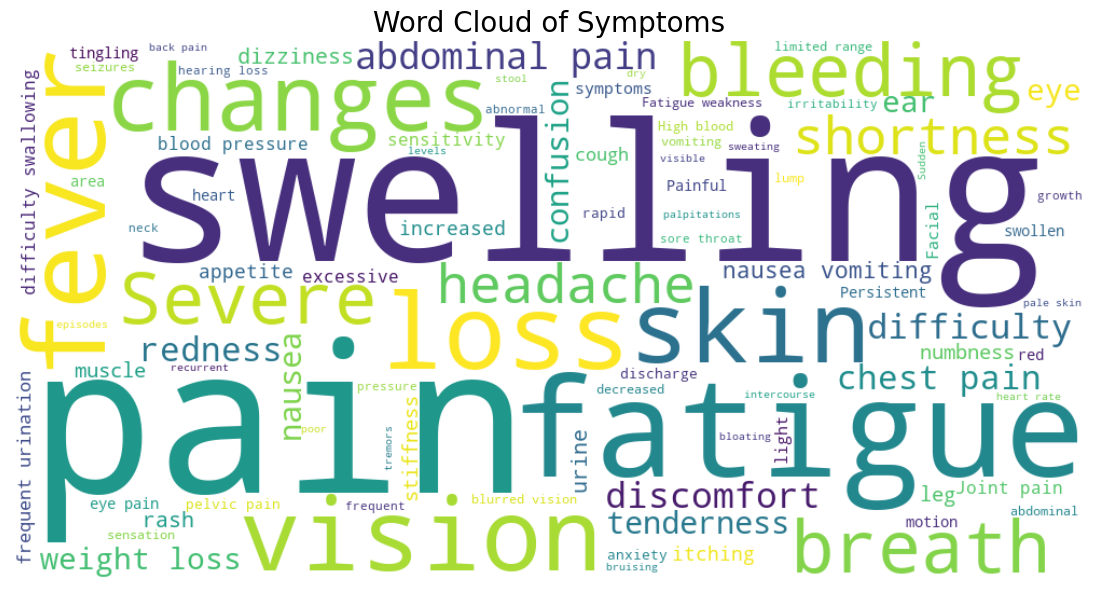

In [4]:
# --- Exploratory Data Analysis (EDA) ---

# First, ensure the DataFrame is not empty before proceeding with EDA
if symptoms_df.empty:
    print("⚠️ DataFrame is empty. Cannot perform Exploratory Data Analysis.")
else:
    # --- Analyze Structured Boolean Features ('Chronic' and 'Contagious') ---
    print("--- 2.1: Distribution of 'Chronic' and 'Contagious' flags ---")

    # Create a figure with two subplots for a side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Distribution of Disease Characteristics', fontsize=18)

    # Plot for 'Chronic'
    sns.countplot(x='Chronic', data=symptoms_df, ax=axes[0], palette='YlGnBu')
    axes[0].set_title('Chronic vs. Non-Chronic Diseases', fontsize=14)
    axes[0].set_xlabel('Is the Disease Chronic?', fontsize=12)
    axes[0].set_ylabel('Number of Diseases', fontsize=12)
    axes[0].set_xticklabels(['False (Not Chronic)', 'True (Chronic)'])

    # Plot for 'Contagious'
    sns.countplot(x='Contagious', data=symptoms_df, ax=axes[1], palette='YlOrRd')
    axes[1].set_title('Contagious vs. Non-Contagious Diseases', fontsize=14)
    axes[1].set_xlabel('Is the Disease Contagious?', fontsize=12)
    axes[1].set_ylabel('') # Hide y-label for cleaner look
    axes[1].set_xticklabels(['False (Not Contagious)', 'True (Contagious)'])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Analyze Text Features ('Symptoms' and 'Treatments') ---
    print("\n--- 2.2: Analysis of Text Feature Lengths ---")
    
    # Check if the value is a string before splitting to handle potential NaN values.
    symptoms_df['symptom_count'] = symptoms_df['Symptoms'].apply(
        lambda x: len(x.split(',')) if isinstance(x, str) else 0
    )
    symptoms_df['treatment_count'] = symptoms_df['Treatments'].apply(
        lambda x: len(x.split(',')) if isinstance(x, str) else 0
    )

    print("\n--- Descriptive Statistics for Symptom and Treatment Counts ---")
    display(symptoms_df[['symptom_count', 'treatment_count']].describe())

    # Visualize the distribution of the number of symptoms
    plt.figure(figsize=(14, 6))
    sns.histplot(symptoms_df['symptom_count'], bins=15, kde=True, color='skyblue')
    plt.title('Distribution of Number of Symptoms per Disease', fontsize=16)
    plt.xlabel('Number of Symptoms', fontsize=12)
    plt.ylabel('Frequency (Number of Diseases)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # --- Analyze Text Content (Most Common Symptom Words) ---
    print("\n--- 2.3: Most Common Words in Symptom Descriptions ---")

    # Use .dropna() to handle potential missing values in the 'Symptoms' column robustly.
    symptoms_text = ' '.join(symptoms_df['Symptoms'].dropna())

    # Generate the word cloud
    wordcloud = WordCloud(width=1000, height=500, background_color='white',
                          colormap='viridis', min_font_size=10).generate(symptoms_text)

    # Display the generated image
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Symptoms', fontsize=20)
    plt.show()

In [5]:
# --- Text Preprocessing ---

def preprocess_text(text):
    """
    A simple preprocessing function to clean and standardize text data.
    - Converts text to lowercase.
    - Removes leading/trailing whitespace.
    
    Args:
        text (str): The input string to be cleaned.
        
    Returns:
        str: The cleaned string. Returns an empty string if input is not a string.
    """
    if not isinstance(text, str):
        return ""
    return text.lower().strip()

if not symptoms_df.empty:
    # Apply this function to the 'Symptoms' column.
    symptoms_df['processed_symptoms'] = symptoms_df['Symptoms'].apply(preprocess_text)
    print("✅ 'processed_symptoms' column created successfully.")
    # Display the original vs. processed text for a few rows to verify
    display(symptoms_df[['Name', 'Symptoms', 'processed_symptoms']].head())
else:
    print("⚠️ DataFrame is empty. Skipping preprocessing.")

✅ 'processed_symptoms' column created successfully.


,Name,Symptoms,processed_symptoms
0,Gestational Cholestasis,"Itchy skin, particularly on the hands and feet","itchy skin, particularly on the hands and feet"
1,Injury to Internal Organ,"Abdominal pain, bleeding, organ dysfunction","abdominal pain, bleeding, organ dysfunction"
2,Scabies,"Intense itching, especially at night, small blisters or bumps","intense itching, especially at night, small blisters or bumps"
3,Congenital Glaucoma,"Cloudy or hazy eyes, excessive tearing, sensitivity to light","cloudy or hazy eyes, excessive tearing, sensitivity to light"
4,Avoidant/Restrictive Food Intake Disorder (ARFID),"Avoidance or restriction of certain foods or entire food groups, significant weight loss or failure to gain weight","avoidance or restriction of certain foods or entire food groups, significant weight loss or failure to gain weight"


In [6]:
# --- Core NLP Model - Symptom Embedding ---

# Initialize the Sentence-Transformer Model
# model_name = 'all-MiniLM-L6-v2'

# New Line Added
model_name = 'paraphrase-MiniLM-L3-v2'

try:
    model = SentenceTransformer(model_name)
    print(f"✅ Sentence-Transformer model '{model_name}' loaded successfully.")
except Exception as e:
    print(f"❌ Error loading Sentence-Transformer model: {e}")
    model = None

# Generate Embeddings for All Symptoms
if model and not symptoms_df.empty:
    symptom_texts = symptoms_df['processed_symptoms'].tolist()
    print("\nGenerating embeddings for all symptoms... (This may take a minute with the full dataset)")
    symptom_embeddings = model.encode(symptom_texts, show_progress_bar=True)
    print("✅ Embeddings generated successfully.")
    print("Shape of the embeddings matrix:", symptom_embeddings.shape)
else:
    print("⚠️ Skipping embedding generation due to model loading failure or empty DataFrame.")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Sentence-Transformer model 'paraphrase-MiniLM-L3-v2' loaded successfully.

Generating embeddings for all symptoms... (This may take a minute with the full dataset)


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

✅ Embeddings generated successfully.
Shape of the embeddings matrix: (405, 384)


In [7]:
# --- Building and Testing the Diagnosis Function ---

def find_top_diseases(query, top_k=5):
    """
    Finds the top_k most similar diseases based on a user's symptom query.
    
    Args:
        query (str): The user's symptom description.
        top_k (int): The number of top matches to return.
        
    Returns:
        pd.DataFrame: A DataFrame containing the top_k matching diseases and their
                      similarity scores, sorted from most to least similar.
    """
    query_processed = preprocess_text(query)
    query_embedding = model.encode(query_processed)
    similarities = cosine_similarity([query_embedding], symptom_embeddings).flatten()
    top_k_indices = np.argsort(similarities)[::-1][:top_k]
    top_matches_df = symptoms_df.iloc[top_k_indices].copy()
    top_matches_df['similarity_score'] = [similarities[i] for i in top_k_indices]
    return top_matches_df

# --- Let's Test Our Function with a sample query! ---
if 'symptom_embeddings' in globals():
    test_query = "I have a sharp pain in my chest and it's hard to breathe"
    print(f"\n--- Testing with query: '{test_query}' ---")
    top_results = find_top_diseases(test_query, top_k=5)
    display(top_results[['Name', 'Symptoms', 'Treatments', 'similarity_score']])
else:
    print("⚠️ Cannot test function because embeddings were not generated.")


--- Testing with query: 'I have a sharp pain in my chest and it's hard to breathe' ---


,Name,Symptoms,Treatments,similarity_score
103,Lung Contusion,"Chest pain (sharp or dull), difficulty breathing or shortness of breath, rapid or shallow breathing, coughing up blood or pink-tinged sputum, decreased oxygen levels, wheezing, cyanosis (bluish discoloration of the skin), chest wall bruising, rib fractures (associated injuries)","Supportive care (including supplemental oxygen, pain management, and respiratory support), monitoring in a hospital setting (to assess lung function and overall stability), treatment of associated injuries (such as rib fractures), management of complications (such as pneumonia or respiratory failure), prevention of further complications (such as deep vein thrombosis or pressure ulcers), respiratory therapy (including breathing exercises and airway clearance techniques), possible use of mechanical ventilation in severe cases",0.774495
57,Atelectasis,"Difficulty breathing, rapid breathing, chest pain","Treatment of the underlying cause (such as removal of airway obstruction, treatment of lung infection), deep breathing exercises, coughing techniques, incentive spirometry, chest physiotherapy, bronchodilator medications, supplemental oxygen therapy",0.773161
129,Pericarditis,"Chest pain (sharp and stabbing), worsens with deep breaths or lying down, fever","Nonsteroidal anti-inflammatory drugs (NSAIDs) to reduce inflammation and pain, colchicine (for recurrent or persistent pericarditis), corticosteroids (in severe cases or when NSAIDs are ineffective), antibiotics (if bacterial infection is present), lifestyle modifications (rest, avoiding strenuous activity), treating underlying causes (if identified), potential pericardiocentesis (fluid drainage)",0.744450
262,Panic Attack,"Chest pain, shortness of breath, palpitations","Breathing exercises, relaxation techniques, therapy",0.734581
152,Fracture of the Rib,"Chest pain, difficulty breathing, tenderness or swelling over the ribcage","Pain management, rest, immobilization (splinting or bracing), physical therapy",0.699222


In [8]:
# --- Saving Artifacts for Deployment ---

output_dir = './model_artifacts'
os.makedirs(output_dir, exist_ok=True)

if 'symptom_embeddings' in globals() and not symptoms_df.empty:
    # Save the Processed DataFrame
    processed_data_path = os.path.join(output_dir, 'processed_diseases.parquet')
    symptoms_df.to_parquet(processed_data_path)

    # Save the Embeddings NumPy Array
    embeddings_path = os.path.join(output_dir, 'symptom_embeddings.npy')
    np.save(embeddings_path, symptom_embeddings)

    print(f"\n✅ Processed data saved to: {processed_data_path}")
    print(f"✅ Embeddings saved to: {embeddings_path}")
    print("\n--- Artifacts are now ready for the Flask application! ---")
else:
    print("⚠️ Artifacts not saved because of a previous error.")


✅ Processed data saved to: ./model_artifacts\processed_diseases.parquet
✅ Embeddings saved to: ./model_artifacts\symptom_embeddings.npy

--- Artifacts are now ready for the Flask application! ---
